**Title**

Diagnosing Heart Disease With Cholesterol and Cardiac Variables


**Introduction**

Cardiovascular disease is a medical condition that affects the body's ability to pump blood and deliver oxygen to parts of the body because of plaque build up in arteries. In extreme cases, plaque build up can completely block an artery and inhibit the ability for the heart to provide blood to certain parts of the body, resulting in heart attacks, strokes and death. Cardiovascular disease is one of the main causes of death worldwide, it is reported that one individual dies every 34 seconds due to some form of heart disease (https://www.cdc.gov/heartdisease/facts). There are multiple condtions that are associated with high risk of cardiovascular disease such as high blood pressure, high cholesterol levels, smoking and a lack of sufficient exercise. In this data analysis we will predict whether or not an individual has heart disease using key factors that are correlated with high risks of cardiovascular disease. To accomplish this task we will use a data set that contains cardiovascular information (such as maximum heart rate, type of chest pain, etc. as well as if they are experience heart disease) of 303 individuals from Cleveland, Ohio from 1988.







**Preliminary Exploratory Data Analysis**


In [1]:
#Load Important Packages
library(tidyverse)
library(dplyr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#Loading Processed Cleveland Data From Heart Disease Data Set
url<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

cleveland_heart_data<-read_csv(url, col_names=FALSE)%>%
rename(age=X1,
       sex=X2,
       cp=X3,
       trestbps=X4,
       chol=X5,
       fbs=X6,
       restecg=X7,
       thalach=X8,
       exang=X9,
       oldpeak=X10,
       slope=X11,
       ca=X12,
       thal=X13,
       num=X14)     
head(cleveland_heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


**Tidying The Data**

In [3]:
cleveland_heart_data$sex<-ifelse(cleveland_heart_data$sex == 1, 'male', 'female')
cleveland_heart_data$fbs<-ifelse(cleveland_heart_data$fbs == 1, '>120', '<120')
cleveland_heart_data$exang<-ifelse(cleveland_heart_data$exang == 1, 'yes', 'no')
cleveland_heart_data$num<-ifelse(cleveland_heart_data$num == 0, 'no_disease', 'has_disease')
#Values 1-4 are considered to be the presence of heart disease (different types) and 0 is absence. We have
#combined 1-4 into a single variable because we are only concerned of the presence for this study.


cleveland_heart_data$cp<-ifelse(cleveland_heart_data$cp == 1, 'typical_angina',
                                ifelse(cleveland_heart_data$cp == 2, 'atypical_angina',
                                       ifelse(cleveland_heart_data$cp == 3, 'non_anginal_pain', 'asymptomatic')))

cleveland_heart_data$restecg<-ifelse(cleveland_heart_data$restecg == 0, 'normal',
                                     ifelse(cleveland_heart_data$restecg == 1, 'abnormal', 'hypertrophy'))

cleveland_heart_data$slope<-ifelse(cleveland_heart_data$slope == 1, 'upsloping',
                                   ifelse(cleveland_heart_data$slope == 2, 'flat', 'downsloping'))

In [4]:
head(cleveland_heart_data)

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
63,male,typical_angina,145,233,>120,hypertrophy,150,no,2.3,downsloping,0.0,6.0,no_disease
67,male,asymptomatic,160,286,<120,hypertrophy,108,yes,1.5,flat,3.0,3.0,has_disease
67,male,asymptomatic,120,229,<120,hypertrophy,129,yes,2.6,flat,2.0,7.0,has_disease
37,male,non_anginal_pain,130,250,<120,normal,187,no,3.5,downsloping,0.0,3.0,no_disease
41,female,atypical_angina,130,204,<120,hypertrophy,172,no,1.4,upsloping,0.0,3.0,no_disease
56,male,atypical_angina,120,236,<120,normal,178,no,0.8,upsloping,0.0,3.0,no_disease


Column Meanings: (From https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

cp = type of chest pain

trestbps = resting blood pressure (mm/Hg)

chol = cholesterol (mg/dl)

fbs = fasting blood sugar (mg/dl)

restecg = electrocardiographic results

thalach = maximum heart rate

exang = exercise induced angina

oldpeak = ST depression induced by exercise relative to rest

slope = the slope of the peak exercise ST segment

ca = number of major vessels colored by flourosopy

thal = defect Type (3.0 = normal, 6.0 = fixed defect, 7.0 = reversible defect)

num = diagnosis

**Table of Count of each Class in Training Data**

In [5]:
class_table<-cleveland_heart_data%>%
group_by(num)%>%
summarize(n=n())
class_table

num,n
<chr>,<int>
has_disease,139
no_disease,164


**Graph/Visualization:**

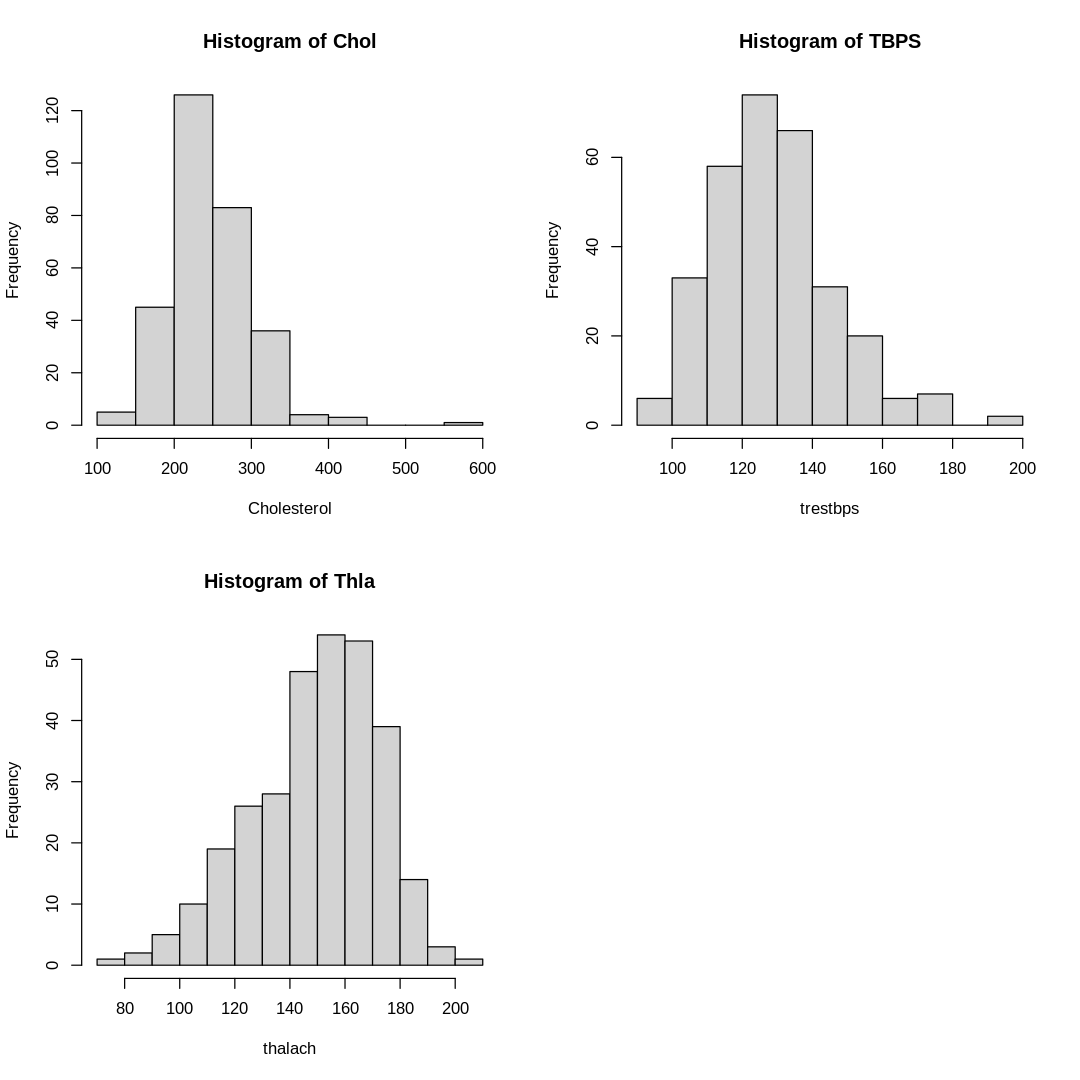

In [6]:
options(repr.plot.width=9,repr.plot.height=9)
viz_test<-attach(cleveland_heart_data)
par(mfrow=c(2,2))
hist(chol, main="Histogram of Chol", xlab="Cholesterol")
hist(trestbps, main="Histogram of TBPS")
hist(thalach, main="Histogram of Thla")

#Missing Restecg Right Now

**Methods**

We will conduct our data analysis by creating a K-Nearest-Neighbor classification algorithim that will predict the presence of heart disease using cholesterol levels, resting blood pressure, maximum heart rate and electrocardiographic information as predictors. The data will be split into a training and testing data set and they will undergoe cross-validation. Furthermore we will tune our classification model to determine the most accurate K value for our data analysis and illustrate this with an accuracy vs neighbors line plot.

**Expected Outcomes and Significance**

We expect to find a model that can predict the presence of heart disease in patients based on measurable predictor values discussed in the Methods section. Heart disease is difficult to diagnose and often requires many tests to be preformed on a patient. If a successful model is found, this will limit the amount of time physicians spend on conducting tests, as they will only need access to the predictors used in this model to make a diagnosis. Physicians will therefore be able to rapidly diagnose patients with heart disease and provide proper care much sooner as less time will be spent on the preliminary testing phases. Future sudies may refine the model to determine if it is possible to predict a specific type of heart disease based on the predictor variables being studied, as the categories of different disease were combined into one variable for this study (see the note in "Tidying The Data" section).